In [1]:
# Importanweisungen

import sys
import numpy as np
import statistics as stat
import scipy as sci
import scipy.fftpack
#import sympy as sym
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import matplotlib.axes as axes
from matplotlib import colors as mcolors
import math
from scipy import optimize
import uncertainties as unc
import uncertainties.unumpy as unp
import uncertainties.umath as umath
unv=unp.nominal_values
usd=unp.std_devs

import os

# Konstanten fuer einheitliche Darstellung

fig_size = (10, 6)
fig_legendsize = 14
fig_labelsize = 12
matplotlib.rcParams.update({'font.size': fig_labelsize})

colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
#colors

# mathe Funktionen
def find_maxima(xarray, yarray, eps=0.):
    #find the positions of the local maxima of yarry array
    #every value with 2 neighbours of lower values gets counted
    #except if it's less than eps away in yarray from the last maximum
    #never uses the outermost values
    #assumes sorted xarray
    result = []
    lastRel = False # true if last value was higher than second to last value
    for i in range(len(xarray)-1):
        if(yarray[i]>=yarray[i+1]):
            if(lastRel):
                if(result==[] or xarray[i]>xarray[result[-1]]+eps): result.append(i)
            lastRel = False
        else: lastRel = True
    return np.array(result)
def find_nearest_index(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
def find_nearest(array, value):
    array[find_nearest_index(array,value)]
def normalize(ydata):
    return (ydata-np.amin(ydata))/(np.amax(ydata)-np.amin(ydata))
def mean(n):
    # find the mean value and add uncertainties
    k = np.mean(n)
    err = stat.variance(unv(n))
    return unc.ufloat(unv(k), math.sqrt(usd(k)**2 + err))

def fft(y):
    N = len(y)
    fft = scipy.fftpack.fft(y)
    return 2 * abs(fft[:N//2]) / N

    # allgemeine Fitfunktionen

def linear(x,m): # lineare Funktion mit f(x) = m * x
    return(m*x)

def gerade(x, m, b): # gerade mit = f(x) = m * x + b
    return (m*x + b)

def cyclic(x, a, f, phi):
    return a * np.sin(x * f - phi)

def cyclicOff(x, a, f, phi, offset):
    return cyclic(x, a, f, phi) + offset

def gauss(x, x0, A, d, y0):
    return A * np.exp(-(x - x0)**2 / 2 / d**2) + y0

def exponential(x, c, y0):
    return np.exp(c * x) * y0

def custom(x,n):
    m = x
    l = 650.4*10**-9#unc.ufloat(630,10)*10**-9
    #l =unp.uarray([630],[10])*10**-9
    #t = unp.uarray([5],[0.1])*10**-3
    t = 5.05*10**-3#unc.ufloat(5,0.1)*10**-3
    return (n*m*l+m*m*l*l/(4*t))/(m*l+2*t*(n-1))

# fittet ein dataset mit gegebenen x und y werten, eine funktion und ggf. anfangswerten und y-Fehler
# gibt die passenden parameter der funktion, sowie dessen unsicherheiten zurueck
#
# https://stackoverflow.com/questions/14581358/getting-standard-errors-on-fitted-parameters-using-the-optimize-leastsq-method-i#
# Updated on 4/6/2016
# User: https://stackoverflow.com/users/1476240/pedro-m-duarte
def fit_curvefit(datax, datay, function, p0=None, yerr=None, **kwargs):
    pfit, pcov = \
         optimize.curve_fit(function,datax,datay,p0=p0,\
                            sigma=yerr, epsfcn=0.0001, **kwargs)
    error = []
    for i in range(len(pfit)):
        try:
          error.append(np.absolute(pcov[i][i])**0.5)
        except:
          error.append( 0.00 )
    pfit_curvefit = pfit
    perr_curvefit = np.array(error)
    return pfit_curvefit, perr_curvefit

# fittet ein dataset mit gegebenen x und y werten, eine funktion und ggf. anfangswerten und y-Fehler
# gibt die passenden parameter der funktion, sowie dessen unsicherheiten zurueck
#
# https://stackoverflow.com/questions/14581358/getting-standard-errors-on-fitted-parameters-using-the-optimize-leastsq-method-i#
# Updated on 4/6/2016
# User: https://stackoverflow.com/users/1476240/pedro-m-duarte
def fit_curvefit2(datax, datay, function, p0=None, yerr=None, **kwargs):
    pfit, pcov = \
         optimize.curve_fit(function,datax,datay,p0=p0,\
                            sigma=yerr, epsfcn=0.0001, **kwargs)
    error = []
    for i in range(len(pfit)):
        try:
          error.append(np.absolute(pcov[i][i])**0.5)
        except:
          error.append( 0.00 )
    pfit_curvefit = pfit
    perr_curvefit = np.array(error)
    return unp.uarray(pfit_curvefit, perr_curvefit)
# usage zB:
# pfit, perr = fit_curvefit(unv(xdata), unv(ydata), gerade, yerr = usd(ydata), p0 = [1, 0])
# fuer eine gerade mit anfangswerten m = 1, b = 0

# weitere Werte, Konstanten
# Werte von https://physics.nist.gov/cuu/Constants/index.html[0]

c = 299792458 # m/s
k_B = unc.ufloat_fromstr("1.38064852(79)e-23") # J K-1 [0]
h = unc.ufloat_fromstr("4.135667662(25)e-15") # eV s [0]
r_e = unc.ufloat_fromstr("2.8179403227(19)e-15") # m [0]
R = unc.ufloat_fromstr("8.3144598(48)") # J mol-1 K-1 [0]
K = 273.15 # kelvin
g = 9.81 # m/s^2
rad = 360 / 2 / math.pi
grad = 1/rad

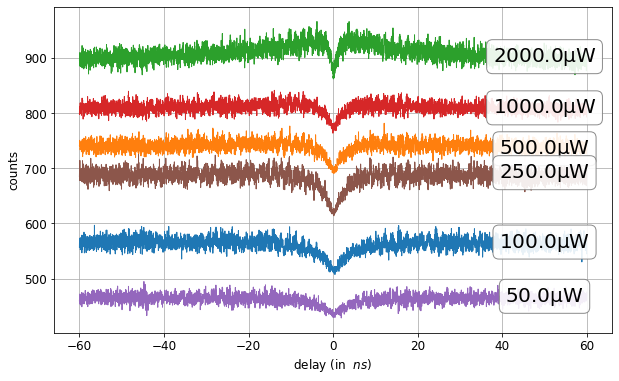

In [17]:
# antibunching auswertung Vergleich aller plots
pathto = "../raw/data_t2/antibunch/"
files = [txt_file for txt_file in os.listdir(pathto) if ".dat" in txt_file]
#print(len(files)) #6

fig=plt.figure(figsize=fig_size)
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)

for f_index in range(6): # 6
    #f_index = 5 # 0-5
    file = files[f_index]
    faktor = [4,6,1.5,2.9,2.5,5.7][f_index]

    data = np.loadtxt(pathto+file, unpack=True, skiprows = 10) #delimiter=","
    power = float(file[9:13]) # power in muW
    ydata1 = unp.uarray(data[0], 10) # measurement
    ydata2 = unp.uarray(data[1], 10) # background
    xdata = unp.uarray(np.arange(len(ydata1)) * 0.025, 0.005) -98.5# delay in ns
    #print(len(xdata))
    low_cutoff = find_nearest_index(xdata, -60)
    high_cutoff = find_nearest_index(xdata, 60)
    #background correction:
    avgI_sg = sum(unv(ydata1[0:600]))/600
    avgI_bg = sum(unv(ydata2[0:600]))/600
    bg_peaks = (ydata2 - avgI_bg) *avgI_sg/avgI_bg /faktor + avgI_sg
    bgc_y = ydata1 - bg_peaks + avgI_sg
    
    id_offset = math.log(power)*110
    plt.plot(unv(xdata[low_cutoff:high_cutoff]), unv(bgc_y[low_cutoff:high_cutoff]) + id_offset,
         label=str(power)+r'$\mathrm{\mu W}$',linewidth='1')
    plt.text(50, unv(bgc_y[high_cutoff]) + id_offset, str(power)+r'$\mathrm{\mu W}$',
            ha="center", va="center", size=20, bbox=bbox_props)

plt.grid()
plt.tick_params(labelsize=fig_labelsize)
plt.xlabel(r'delay (in  $ns$)')
plt.ylabel(r'counts')
#plt.legend()
plt.savefig("../img/output_t2/massvgl_bgcorr.png")
plt.show()

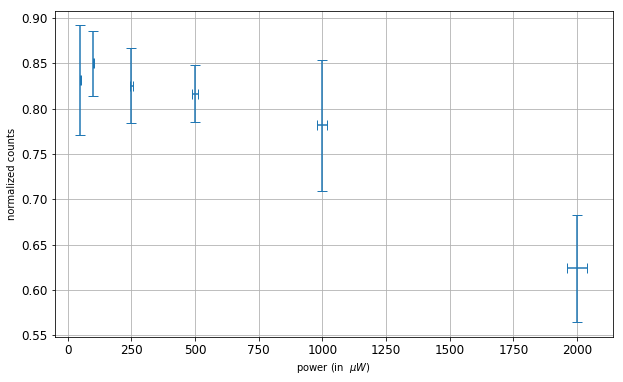

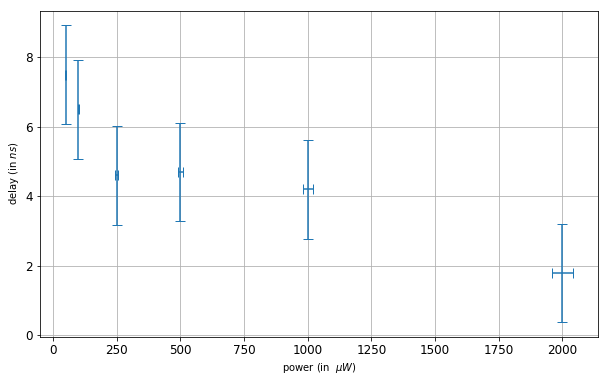

In [4]:
# dip width und depth plots:
# antibunching auswertung
pathto = "t2_img/"
file = "dip_data.txt"
data = np.loadtxt(pathto+file, unpack=True, skiprows = 3) #delimiter=","
power = unp.uarray(data[0], data[0]*0.02) # power mit 2% error in muW 
depthLow = unp.uarray(data[1], data[2]) # low point of depth in counts
depthHigh = unp.uarray(data[3], data[4]) # high point of depth in counts
depth = (depthHigh - depthLow) / depthHigh # depth of dip, normalized
widthL = unp.uarray(data[5], 1)
widthR = unp.uarray(data[6], 1)
width = widthR - widthL # full width at half minimum

# dip depth
fig=plt.figure(figsize=fig_size)
plt.errorbar(unv(power),unv(depth), xerr=usd(power), yerr=usd(depth),fmt=' ', capsize=5)
plt.grid()
plt.tick_params(labelsize=fig_labelsize)
plt.xlabel(r'power (in  $\mu W$)')
plt.ylabel(r'normalized counts')
#plt.savefig("t2_img/dip_depth.png")
plt.show()

# dip width
fig=plt.figure(figsize=fig_size)
plt.errorbar(unv(power),unv(width), xerr=usd(power), yerr=usd(width),fmt=' ', capsize=5)
plt.grid()
plt.tick_params(labelsize=fig_labelsize)
plt.xlabel(r'power (in  $\mu W$)')
plt.ylabel(r'delay (in $ns$)')
#plt.savefig("t2_img/dip_width.png")
plt.show()

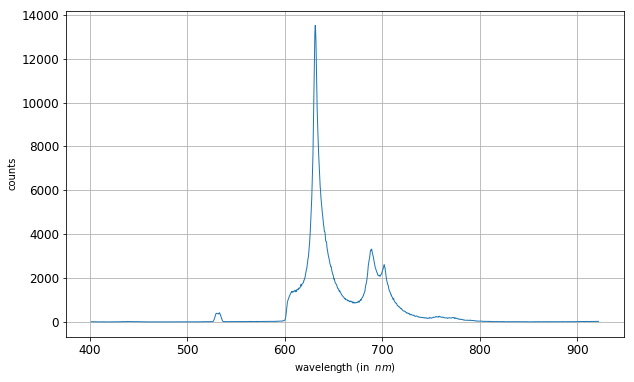

In [5]:
# spectra example
pathto = "data_t2/spectra/"
files = [txt_file for txt_file in os.listdir(pathto) if ".txt" in txt_file]
#print(files)
file = files[0]

data = np.loadtxt(pathto+file, unpack=True, skiprows = 0) #delimiter=","
power = unc.ufloat(float(file[8:11]), float(file[8:11])*0.02) # power in muW, 2% error
xdata = unp.uarray(data[0], data[0]*0.1) # wavelength in nm
ydata = unp.uarray(data[1], 5) # counts vmtl.
# do constant background subtraction:
bg_end = len(unv(xdata))-1
bg_start = int(bg_end * 0.95)
const_bg = sum(unv(ydata[bg_start:]))/(bg_end-bg_start+1)
ydata = ydata -const_bg

fig=plt.figure(figsize=fig_size)
plt.plot(unv(xdata), unv(ydata), label='measurement',linewidth='1')
plt.grid()
plt.tick_params(labelsize=fig_labelsize)
plt.xlabel(r'wavelength (in  $nm$)')
plt.ylabel(r'counts')
#plt.savefig("t2_img/spektrum_example_bgcorr_"+str(power)+"muW.png")
plt.show()

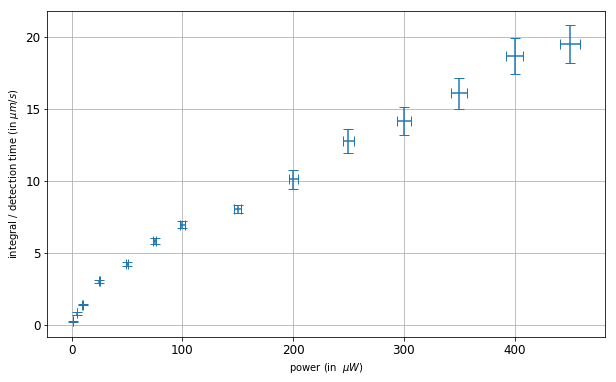

In [6]:
# spectra example
pathto = "data_t2/spectra/"
files = [txt_file for txt_file in os.listdir(pathto) if ".txt" in txt_file]
integrals = unp.uarray(np.zeros(len(files)), 0) #uarray of zeros
powers = unp.uarray(np.zeros(len(files)), 0) #uarray of zeros
for i,file in enumerate(files):
    data = np.loadtxt(pathto+file, unpack=True, skiprows = 0) #delimiter=","
    power = unc.ufloat(float(file[8:11]), float(file[8:11])*0.02) # power in muW, 2% error
    powers[i] = power
    xdata = unp.uarray(data[0], data[0]*0.1) # wavelength in nm
    ydata = unp.uarray(data[1], 5) # counts vmtl.
    # do constant background subtraction:
    bg_end = len(unv(xdata))-1
    bg_start = int(bg_end * 0.95)
    const_bg = sum(unv(ydata[bg_start:]))/(bg_end-bg_start+1)
    ydata = ydata -const_bg

    cwl_max = scipy.integrate.simps(unv(ydata)+usd(ydata), unv(xdata))
    cwl_min = scipy.integrate.simps(unv(ydata)-usd(ydata), unv(xdata))
    cwl = unc.ufloat(cwl_max/2+cwl_min/2, (cwl_max-cwl_min)/2)
    integrals[i] = cwl * 1e-3 / unc.ufloat(float(file[15:17]), 2)

fig=plt.figure(figsize=fig_size)
plt.errorbar(unv(powers),unv(integrals), xerr=usd(powers), yerr=usd(integrals),fmt=' ', capsize=5)
plt.grid()
plt.tick_params(labelsize=fig_labelsize)
plt.xlabel(r'power (in  $\mu W$)')
plt.ylabel(r'integral / detection time (in $\mu m/s$)')
#plt.savefig("t2_img/integrals.png")
plt.show()